Test using quasi-Newton method to update theta

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn, gen_sini_Xthetas
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear, SIS_ballcor
from hdf_utils.utils import gen_lam_seq
from hdf_utils.hypo_test import  MS2idxs, obt_test_stat_simple2
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv, gen_Dmat 
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl, bcross_entropy_loss
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_logi_fn
from optimization.opt import optimization
from penalties.scad_pen import SCAD
from models.logistic_model import LogisticModel
from optimization.variable_selection import GIC_fn, GCV_fn

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Params

In [84]:
np.random.seed(0)
#obt_bsp = obt_bsp_obasis_Rfn
obt_bsp = obt_bsp_basis_Rfn_wrapper
paras = edict(def_paras.copy())



# Others
paras.num_rep = 200 
paras.init_noise_sd = -1 # the sd of the noise added to the true value for initial values, if -1, make init 0
paras.SIS_ratio = 0.20 # the ratio to keep with SIS procedure
paras.linear_theta_update="cholesky_inv"

# candidate sets of tuning parameters, only two 
# lambda: penalty term
# N: num of basis
paras.can_lams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1, 2, 8] # for non
paras.can_lams = [0.001, 0.3, 0.6, 0.8, 1, 1.2, 1.4, 2, 16] # for orthogonal basis
paras.can_Ns = [4, 6, 8]


# generating dataset
paras.n = 200 # num of data obs to be genareted
paras.npts = 100 # num of pts to evaluate X(s)
paras.d = 50 # num of ROIs
paras.q = 3 # num of other covariates
paras.types_ = ["int", "c", "c"]
paras.srho = 0.3 # corr from sinica

# b-spline
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mats = []
for N in paras.can_Ns:
    paras.basis_mats.append(
        torch.tensor(obt_bsp(paras.x, N, paras.ord)).to(torch.get_default_dtype())
    )

# True parameters
paras.alp_GT = np.array([3, -1, 5])
# fourier basis
cs = [0.0, 0.0, 0.0] # for sinica paper
paras.fourier_basis = fourier_basis_fn(paras.x)[:, :]
paras.fourier_basis_coefs = ([cs[0]*coef_fn(0.2), cs[1]*coef_fn(0.2), cs[2]*coef_fn(0.2)] + 
                             [np.zeros(50)] * (paras.d-3-1) +
                             [coef_fn(0.2)]
                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T 
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs
print(np.linalg.norm(paras.beta_GT, axis=0))

paras.Gam_GT_ests = [(np.linalg.inv(basis_mat.numpy().T 
                                  @ basis_mat.numpy()) 
                                  @ basis_mat.numpy().T 
                                  @ paras.beta_GT) 
                     for basis_mat in paras.basis_mats]

# optimization
# not used, to use it, you have to know GT
#Rmins = [(2*(np.linalg.norm(paras.Gam_GT_ests[ix]
#                            /np.sqrt(paras.can_Ns[ix]), axis=0).sum() 
#           + np.abs(paras.alp_GT).sum())) 
#        for ix in range(len(paras.can_Ns))]
#paras.Rmin = np.max(Rmins)
paras.Rmin = 100000
paras.Rfct = 2
paras.stop_cv = 5e-4
paras.max_iter = 10000
paras.num_cv_fold = 5

paras.NR_eps = 1e-4 # the stop criteria for Newton-Ralpson method, only for logistic model
paras.NR_maxit = 100

paras.cv_is_center = True
paras.cv_SIS_ratio = 0.2
paras.cv_SIS_pen = 1
paras.cv_SIS_basis_mat = torch.tensor(obt_bsp(paras.x, 6, paras.ord)).to(torch.get_default_dtype())
paras.num_cv_fold = 5
paras.cv_init_noise_sd = -1


# hypothesis test
#without loss of generality, we assume the idxs in M is the first m betas
paras.sel_idx = np.arange(1, paras.d) # M^c set, 
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmats = [
    np.eye(len(paras.M_idxs)), # m x m I matrix, [beta1, beta2] = [0, 0]
]
paras.svdinv_eps_Q = 1e-7 # now 0 means inverse, small value like 0.01 means remove small eig vals.
paras.svdinv_eps_Psi = 1e-7

paras.save_dir = RES_ROOT/"simu_linear_sinica_samebetaX_tmp"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         14.87358566]


## Fns

In [7]:
def _gen_simu_data_all(seed, paras, verbose=False):
    """
    Generate simulated data for all parameters.

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - srho: corr from sinica
            - fourier_basis: The fourier basis for generating X, npts x nbasis
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not

    Returns:
        all_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
    """
    torch.set_default_tensor_type(torch.DoubleTensor)
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    con_idxs = [typ =="c" for typ in _paras.types_]
   
    thetas = gen_sini_Xthetas(_paras.srho, _paras.n, _paras.d);
    simu_curvs = thetas @ _paras.fourier_basis.T; # n x d x npts
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts)*10
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    probs = logit_fn(lin_term)
    
    # Y 
    Y = np.random.binomial(1, probs, size=len(probs))
    
    X_centered = simu_curvs - simu_curvs.mean(axis=0, keepdims=True)
    # this step is not necessary for simulation as I did so in generating data step
    # but for real data, plz do this
    Z_std = simu_covs.copy()
    Z_std[:, con_idxs] = (simu_covs[:, con_idxs] - simu_covs[:, con_idxs].mean(axis=0, keepdims=True))/simu_covs[:, con_idxs].std(axis=0, keepdims=True)
    
    
    # To torch
    X = torch.Tensor(X_centered) # n x d x npts
    Z = torch.Tensor(Z_std) # n x q
    Y = torch.Tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    all_data.lin_term = lin_term
    return all_data

# Simu

## In one step

In [13]:
_paras = edict(paras.copy())
_paras.Rv = _paras.Rfct * _paras.Rmin
_paras.seed = 0
_paras.lam = 0.2
_paras.N = 8
_paras.basis_mat = _paras.basis_mats[_paras.can_Ns.index(_paras.N)]
_paras.Gam_GT_est = paras.Gam_GT_ests[_paras.can_Ns.index(_paras.N)]
cur_data = _gen_simu_data_all(_paras.seed, _paras)
    
res = edict()
keep_idxs, _  = SIS_ballcor(cur_data.Y, cur_data.X, _paras.sel_idx, _paras.SIS_ratio)
M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
_paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
                    
_paras.sel_idx_SIS = np.where(np.array([keep_idx in _paras.sel_idx for keep_idx in _paras.keep_idxs]))[0]
_paras.d_SIS = len(_paras.keep_idxs)
                
cur_data_SIS = edict(cur_data.copy())
cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
                
                
alp_init = torch.zeros(_paras.q)
Gam_init = torch.zeros(_paras.N, _paras.d_SIS)
theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
rhok_init = torch.zeros(_paras.d_SIS*_paras.N)
            
model = LogisticModel(Y=cur_data_SIS.Y, 
                              X=cur_data_SIS.X, 
                              Z=cur_data_SIS.Z, 
                              basis_mat=_paras.basis_mat)
pen = SCAD(lams=_paras.lam, a=_paras.a,  sel_idx=_paras.sel_idx_SIS)

In [18]:
def _update_theta_NR(thetak, rhok, Gamk, model, paras):
    """First step of optimization, update theta 
           This step can be slow
    """
    paras = edict(paras.copy())
    D = gen_Dmat(paras.d_SIS, paras.N, paras.q)
    thetal = thetak
    alpl = thetal[:paras.q]
    Gaml = col_vec2mat_fn(thetal[paras.q:], nrow=paras.N)*np.sqrt(paras.N)
    for ix in range(paras.N_maxit):
        der1_p1 = -model.log_lik_der1(alpl, Gaml)
        der1_p2 = -D.T @ rhok
        der1_p3 = paras.beta * (D.T@D@thetal - D.T@col_vec_fn(Gamk)/np.sqrt(paras.N))
        der1 = der1_p1 + der1_p2 + der1_p3
            
        der2_p1 = -model.log_lik_der2(alpl, Gaml)
        der2_p2 = paras.beta * D.T @ D 
        der2 = der2_p1 + der2_p2 
            
        theta_last = thetal.clone()
        #der2_inv = svd_inverse(der2)
        der2_inv = torch.linalg.pinv(der2, hermitian=True, rtol=1e-7)
        thetal = theta_last - der2_inv @ der1 # update 
        alpl = thetal[:paras.q]
        Gaml = col_vec2mat_fn(thetal[paras.q:], nrow=paras.N)*np.sqrt(paras.N)
            
        stop_cv = torch.norm(thetal-theta_last)/torch.norm(thetal)
        if stop_cv <= paras.N_eps:
            break
    if ix == (paras.N_maxit-1):
        print("The NR algorithm may not converge")
    return thetal, ix

In [19]:
def _update_theta_BFGS(thetak, rhok, Gamk, model, paras):
    def _obj_fn(thetalk):
        alplk = thetalk[:paras.q]
        Gamlk = col_vec2mat_fn(thetalk[paras.q:], nrow=paras.N)*np.sqrt(paras.N)
        der0_p1 = -model.log_lik(alplk, Gamlk)
        der0_p2 = - rhok @ (D @ thetalk - col_vec_fn(Gamk)/np.sqrt(paras.N))
        der0_p3 = paras.beta * torch.norm(D @ thetalk - col_vec_fn(Gamk)/np.sqrt(paras.N), p=2)**2/2
        der0 = der0_p1 + der0_p2 + der0_p3
        return der0
    
    def _obj_fn_der1(thetalk):
        alplk = thetalk[:paras.q]
        Gamlk = col_vec2mat_fn(thetalk[paras.q:], nrow=paras.N)*np.sqrt(paras.N)
        der1_p1 = -model.log_lik_der1(alplk, Gamlk)
        der1_p2 = -D.T @ rhok
        der1_p3 = paras.beta * (D.T@D@thetalk - D.T@col_vec_fn(Gamk)/np.sqrt(paras.N))
        der1 = der1_p1 + der1_p2 + der1_p3
        return der1
    
    def _obj_fn_der2(thetalk):
        alplk = thetalk[:paras.q]
        Gamlk = col_vec2mat_fn(thetalk[paras.q:], nrow=paras.N)*np.sqrt(paras.N)
        der2_p1 = -model.log_lik_der2(alplk, Gamlk)
        der2_p2 = paras.beta * D.T @ D 
        der2 = der2_p1 + der2_p2 
        return der2
    
    def _wolfe_cond_check(stepsizel, c1=1e-4, c2=0.9):
        left1 = _obj_fn(thetal+stepsizel*dlt_thetal_raw)-_obj_fn(thetal)
        right1 = c1*stepsizel*dlt_thetal_raw @ der1
        
        left2 = - dlt_thetal_raw @ _obj_fn_der1(thetal+stepsizel*dlt_thetal_raw)
        right2 = -c2* dlt_thetal_raw @ der1
        return (left1 <= right1).float() +  (left2 <= right2).float()
    
    paras = edict(paras.copy())
    D = gen_Dmat(paras.d_SIS, paras.N, paras.q)
    
    # initial
    thetal = thetak
    der1 = _obj_fn_der1(thetal)
    stepsizel = 1
    Binvl = torch.eye(thetal.shape[0])
    #Binvl = svd_inverse(_obj_fn_der2(thetal))
    for ix in range(paras.N_maxit):
        # get move step 
        dlt_thetal = - stepsizel * Binvl @ der1
        
        # stop criterion 
        stop_cv = torch.norm(dlt_thetal)/torch.norm(thetal)
        if (stop_cv <= paras.N_eps) and (ix >=2):
            break
            
        # get new thetal
        thetal = thetal + dlt_thetal
        
        
        # save old der1
        der1_last = der1.clone()
        
        # new der1
        der1 = _obj_fn_der1(thetal)
        
        # yl
        yl = der1 - der1_last
        
        # get new Binvl
        Binvl_p1 = torch.eye(thetal.shape[0]) - torch.outer(dlt_thetal, yl)/(torch.inner(dlt_thetal, yl))
        Binvl_p2 = torch.outer(dlt_thetal, dlt_thetal)/(torch.inner(dlt_thetal, yl))
        Binvl = Binvl_p1 @ Binvl @ Binvl_p1.T + Binvl_p2
        #Binvl = svd_inverse(_obj_fn_der2(thetal))
        
        # get step size
        dlt_thetal_raw = -Binvl @ der1
        can_stepsizes = torch.linspace(1e-4, 5, 10)
        obj_fns = [_obj_fn(thetal+can_stepsize*dlt_thetal_raw).item() for can_stepsize in can_stepsizes]
        stepsizel = can_stepsizes[np.argmin(obj_fns)]
        #stepsizel = 1
        
        if False:
            _wolfe_cond_check(stepsizel)
    
    if ix == (paras.N_maxit-1):
        print("The BGFS algorithm may not converge")
    return thetal, ix

In [59]:
%timeit resNR = _update_theta_NR(theta_init, rhok_init, Gam_init, model, _paras);

129 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
%timeit resQN = _update_theta_BFGS(theta_init, rhok_init, Gam_init, model, _paras);

46.7 ms ± 75.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
resNR = _update_theta_NR(theta_init, rhok_init, Gam_init, model, _paras);
resQN = _update_theta_BFGS(theta_init, rhok_init, Gam_init, model, _paras);

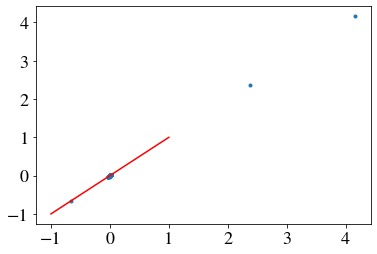

In [21]:
plt.plot(resNR[0], resQN[0], ".")
x = np.linspace(-1, 1, 100)
plt.plot(x, x, color="red")

## IN the whole procedure

In [85]:

def _run_fn(seed, lam, N, paras, verbose=False):
    _paras = edict(paras.copy())
    _paras.Rv = _paras.Rfct * _paras.Rmin
    _paras.seed = seed
    _paras.lam = lam
    _paras.N = N
    _paras.basis_mat = _paras.basis_mats[_paras.can_Ns.index(N)]
    _paras.Gam_GT_est = paras.Gam_GT_ests[_paras.can_Ns.index(N)]
    cur_data = _gen_simu_data_all(_paras.seed, _paras)
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}-c1_{cs[0]*1000:.0f}_estfasf.pkl"
        
    res = edict()
    if not (_paras.save_dir/f_name).exists():
        if _paras.SIS_ratio < 1:
            keep_idxs, _  = SIS_ballcor(cur_data.Y, cur_data.X, _paras.sel_idx, _paras.SIS_ratio)
        else:
            keep_idxs = _paras.sel_idx
        M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
        _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
                    
        _paras.sel_idx_SIS = np.where(np.array([keep_idx in _paras.sel_idx for keep_idx in _paras.keep_idxs]))[0]
        _paras.d_SIS = len(_paras.keep_idxs)
                
        cur_data_SIS = edict(cur_data.copy())
        cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
                
                
        if _paras.init_noise_sd < 0:
            alp_init = torch.zeros(_paras.q)
            Gam_init = torch.zeros(_paras.N, _paras.d_SIS)
            theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
            rhok_init = torch.zeros(_paras.d_SIS*_paras.N)
        else:
            alp_init = torch.Tensor(_paras.alp_GT) + torch.randn(_paras.q)*_paras.init_noise_sd
            Gam_init = torch.Tensor(_paras.Gam_GT_est[:, _paras.keep_idxs]) + torch.randn(_paras.N, _paras.d_SIS)*_paras.init_noise_sd
            theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
            rhok_init = torch.randn(_paras.d_SIS*_paras.N)
            
        model = LogisticModel(Y=cur_data_SIS.Y, 
                              X=cur_data_SIS.X, 
                              Z=cur_data_SIS.Z, 
                              basis_mat=_paras.basis_mat)
        pen = SCAD(lams=_paras.lam, a=_paras.a,  sel_idx=_paras.sel_idx_SIS)
                    
                
        main_res = optimization(model=model, 
                                penalty=pen, 
                                inits=[alp_init, Gam_init, theta_init, rhok_init],
                                is_prg=verbose,
                                save_paras=False,    
                                input_paras=_paras)
        opt = main_res[0]
        est_beta = (_paras.basis_mat @ opt.Gamk).numpy()
        
        est_Gam = opt.Gamk
        est_alp = opt.alpk
        Q_mat = -model.log_lik_der2(est_alp, est_Gam)
        model.log_lik_der1(est_alp, est_Gam);
        Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
        est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
        nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
        MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
        keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
        Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
        Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
        
        res._paras = _paras
        res.Q_mat_part = Q_mat_part
        res.Sig_mat_part = Sig_mat_part
        res.est_alp = est_alp
        res.est_Gam = est_Gam
        
        
    return res

In [86]:
paras.is_BFGS = False
res1  = _run_fn(seed=1, lam=0.05, N=4, paras=paras, verbose=True);

  9%|████████▎                                                                                        | 862/10000 [00:02<00:27, 337.97it/s, error=0.000501, GamL0=1, CV=0.0005]


In [92]:
paras.is_BFGS = True
%timeit res2  = _run_fn(seed=1, lam=0.05, N=4, paras=paras, verbose=True);

  9%|████████▎                                                                                        | 862/10000 [00:01<00:16, 560.89it/s, error=0.000501, GamL0=1, CV=0.0005]

2.11 s ± 30 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
paras.is_BFGS = True
%timeit res2  = _run_fn(seed=1, lam=0.05, N=4, paras=paras, verbose=True);

  9%|████████▎                                                                                        | 862/10000 [00:01<00:15, 591.72it/s, error=0.000501, GamL0=1, CV=0.0005]

2.11 s ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
torch.norm(res1.est_alp - res2.est_alp)/torch.norm(res1.est_alp)

tensor(0.0003)

In [89]:
torch.norm(res1.est_Gam - res2.est_Gam)/torch.norm(res1.est_Gam)

tensor(0.0002)

In [90]:
res1.est_alp

tensor([ 2.3634, -0.9962,  3.3454])

In [91]:
res2.est_alp

tensor([ 2.3627, -0.9959,  3.3443])